In [3]:
import numpy as np
import pysindy as ps
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from pysindy.differentiation import SmoothedFiniteDifference

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [4]:
def create_time_series(func, dt, t_end, init):
    t_train = np.arange(0, t_end, dt)
    t_train_span = (t_train[0], t_train[-1])
    # initial condition as a list of two entries: [x1, x2]
    x0_train = init
    x_train = solve_ivp(func, t_train_span, x0_train,
                    t_eval=t_train, **integrator_keywords).y.T
    return x_train

def find_equations(func, x_train, dt, plot):
    diff_method = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    opt = ps.optimizers.STLSQ(threshold=0.01, alpha = 0.1, max_iter=500, normalize_columns=True)
    # up to 3rd degree for van der pol
    lib = ps.PolynomialLibrary(degree=3).fit(x_train)
    model = ps.SINDy(optimizer=opt, 
                        feature_library=lib, 
                        differentiation_method=diff_method,
                        feature_names=['x1', 'x2'])
    model.fit(x_train, t=dt)
    model.print()
    print('Train Model score: %f' %model.score(x_train, dt))
    # Evolve the van der pol equations in time using a different initial condition
    t_test = np.arange(0, 20, dt)
    x0_test = np.array([0, 1.5])
    t_test_span = (t_test[0], t_test[-1])
    x_test = solve_ivp(func, t_test_span, x0_test,
                    t_eval=t_test, **integrator_keywords).y.T
    # Compare SINDy-predicted derivatives with finite difference derivatives
    print('Model score: %f' % model.score(x_test, t=dt))
    if plot:
        # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(x_test)

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(x_test, t=dt)

        fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
        for i in range(x_test.shape[1]):
            axs[i].plot(t_test, x_dot_test_computed[:, i],
                        'k', label='numerical derivative')
            axs[i].plot(t_test, x_dot_test_predicted[:, i],
                        'r--', label='model prediction')
            axs[i].legend()
            axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
    return model

(x1)' = -1.000 x2
(x2)' = 1.000 x1 + -1.000 x2 + 1.000 x1^2 x2
Train Model score: 1.000000
Model score: 1.000000
(x1)' = -1.000 x2
(x2)' = 1.000 x1 + -1.000 x2 + 1.000 x1^2 x2
Train Model score: 1.000000
Model score: 1.000000
(x1)' = -1.000 x2
(x2)' = 1.000 x1 + -1.000 x2 + 1.000 x1^2 x2
Train Model score: 1.000000
Model score: 1.000000


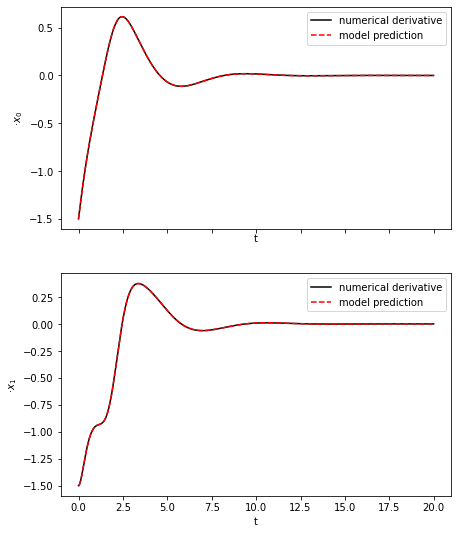

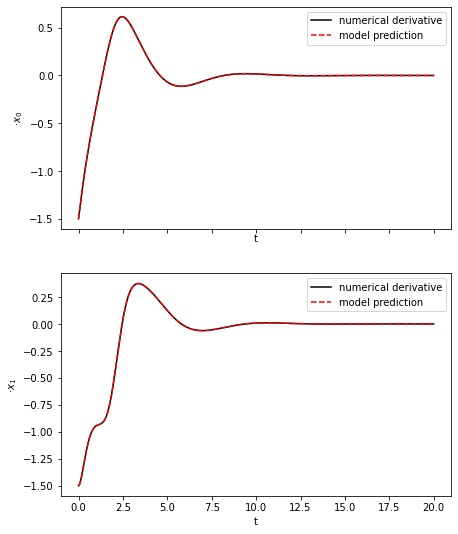

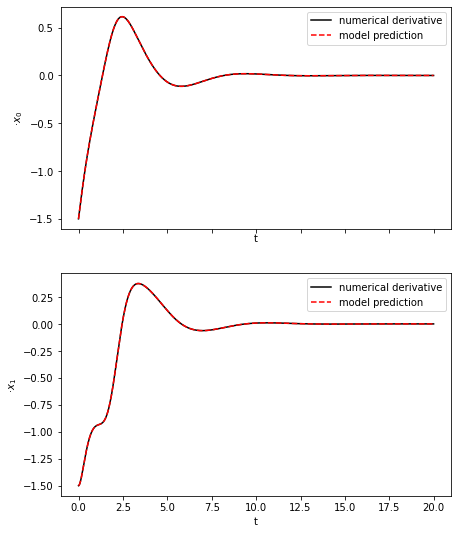

In [5]:
# Van der Pol ODE
def van_der_pol(t, x, p=[1]):
    return [-x[1], - p[0] * (1 - x[0] ** 2) * x[1] + x[0]]

dt = .01
t_end = 20
init = [[0, 2], [1, 2], [-0.5, 1.5]]
for ini in init:
    x_train = create_time_series(van_der_pol, dt, t_end, ini)
    model = find_equations(van_der_pol, x_train, dt, plot = True)


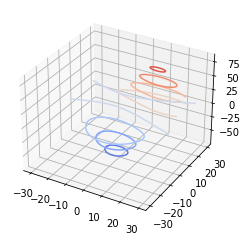

In [3]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

ax = plt.figure().add_subplot(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)

ax.contour(X, Y, Z, cmap=cm.coolwarm)  # Plot contour curves

plt.show()

In [4]:
print(X.shape, Y.shape, Z.shape)

(120, 120) (120, 120) (120, 120)


(512,)


/Users/lysi2/Documents/UNI_Imperial/Deep_Learning/DL/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


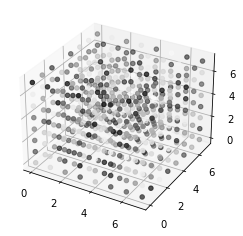

In [8]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Make this bigger to generate a dense grid.
N = 8

# Create some random data.
volume = np.random.rand(N, N, N)

# Create the x, y, and z coordinate arrays.  We use 
# numpy's broadcasting to do all the hard work for us.
# We could shorten this even more by using np.meshgrid.
x = np.arange(volume.shape[0])[:, None, None]
y = np.arange(volume.shape[1])[None, :, None]
z = np.arange(volume.shape[2])[None, None, :]
x, y, z = np.broadcast_arrays(x, y, z)
print(x.ravel().shape)
# Turn the volumetric data into an RGB array that's
# just grayscale.  There might be better ways to make
# ax.scatter happy.
c = np.tile(volume.ravel()[:, None], [1, 3])

# Do the plotting in a single call.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(),
           c=c)

ValueError: Argument Z must be 2-dimensional.

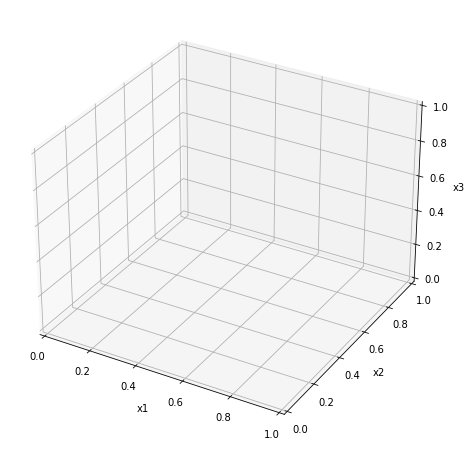

In [9]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Make this bigger to generate a dense grid.
N = 8

# Create some random data.
volume = np.random.rand(N, N, N)

# Create the x, y, and z coordinate arrays.  We use 
# numpy's broadcasting to do all the hard work for us.
# We could shorten this even more by using np.meshgrid.
x = np.arange(volume.shape[0])[:, None, None]
y = np.arange(volume.shape[1])[None, :, None]
z = np.arange(volume.shape[2])[None, None, :]
x, y, z = np.broadcast_arrays(x, y, z)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# ax.set_title('m = {}'.format(m))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3');

ax.plot_surface(x, y, z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')


ValueError: Argument Z must be 2-dimensional.

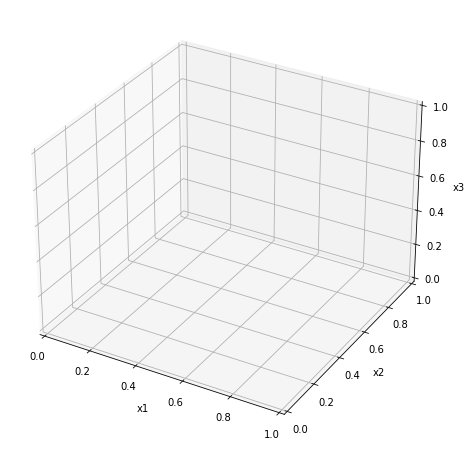

In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

bounds = [1,1,1]
numpoints = 25
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)
z = np.linspace(-bounds[2], bounds[2], numpoints)

X, Y, Z = np.meshgrid(x, y, z)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**3,3))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        for k in range(s[2]):
            DT[c,0] = X[i,j,k]
            DT[c,1] = Y[i,j,k]
            DT[c,2] = Z[i,j,k]
            c = c+1;

# this could be any function that returns a shape (numpoints**3,)
Ep = np.square(DT)[:,0]

c = 0
for i in range(s[0]):
    for j in range(s[1]):
        for k in range(s[2]):
            Zp[i,j,k] = Ep[c]
            c = c+1;

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# ax.set_title('m = {}'.format(m))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3');
ax.plot_surface(X, Y, Zp, rstride=1, cstride=1,cmap='viridis', edgecolor='none')



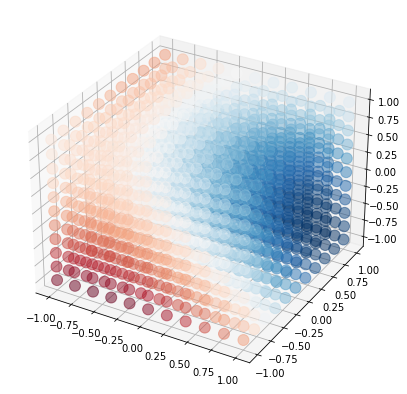

In [4]:
bounds = [1,1,1]
numpoints = 11
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)
z = np.linspace(-bounds[2], bounds[2], numpoints)

X, Y, Z = np.meshgrid(x, y, z)
f_xyz = np.sin(X+Y)+np.cos(Y+Z)
plt.figure(figsize=(7,7))
ax = plt.subplot(projection="3d")
ax.scatter(X, Y, Z, s=120, alpha=.5, c=f_xyz, cmap="RdBu")
plt.show()

In [17]:
import pandas as pd
results = {'Zp': Zp[:,:,0], 'Ze': Zp[:,:,0]}
pd.DataFrame.from_dict(data=results).to_csv('trial.csv', index = True, header=list(results.keys()))

ValueError: If using all scalar values, you must pass an index

In [13]:
Zp[:,:,0].shape

(25, 25)